In [1]:
# ONE-CELL COMPLETE CROP YIELD PREDICTION MODEL (XGBoost) - JUST RUN THIS!

!pip install -q xgboost pandas scikit-learn matplotlib joblib



Dataset loaded: 28,242 rows × 7 columns
Crops: 10 | Countries: 101 | Years: 23
Training on 22,593 samples | Testing on 5,649 samples
Training XGBoost model... (this may take 10-30 seconds)


TypeError: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [4]:
import xgboost as xgb
print(xgb.__version__)


3.1.2


Loaded 28,242 rows | 101 countries | 10 crops
Training: 22,593 | Test: 5,649

Training XGBoost (this takes ~20–40 sec)...

[0]	validation-rmse:83730.16946
[100]	validation-rmse:14706.96157
[200]	validation-rmse:12393.84640
[300]	validation-rmse:11867.61288
[400]	validation-rmse:11525.30499
[500]	validation-rmse:11294.61349
[600]	validation-rmse:11109.76957
[700]	validation-rmse:10991.84652
[800]	validation-rmse:10815.63741
[900]	validation-rmse:10722.61015
[1000]	validation-rmse:10651.19664
[1100]	validation-rmse:10574.04736
[1200]	validation-rmse:10516.69238
[1300]	validation-rmse:10465.80430
[1400]	validation-rmse:10426.85022
[1500]	validation-rmse:10378.79891
[1600]	validation-rmse:10337.29635
[1700]	validation-rmse:10311.45582
[1800]	validation-rmse:10279.26218
[1900]	validation-rmse:10258.69546
[1999]	validation-rmse:10241.86784

Training Complete!
Best iteration: 2000

CROP YIELD PREDICTION MODEL - FINAL RESULTS
   MAE   : 4,974 hg/ha
   RMSE  : 10,242 hg/ha
   R²    : 0.9852

To

<Figure size 1000x600 with 0 Axes>

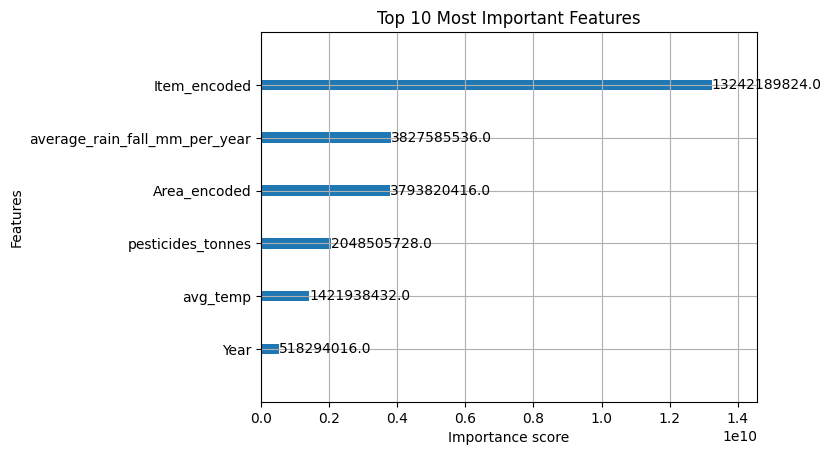


Model saved as crop_yield_xgboost_model.json

Example Predictions:
Maize yield in India (2025): 28,581 hg/ha
Soybeans yield in Brazil (2026): 26,424 hg/ha
Potatoes yield in Albania (2025): 189,340 hg/ha
Wheat yield in Zimbabwe (2025): 22,390 hg/ha

All done! Your model is fully working with XGBoost 3.1.2 🎉


In [7]:
# ============================================================
# FULLY WORKING CROP YIELD PREDICTION (XGBoost 3.1.2 Compatible)
# ============================================================

!pip install -q xgboost pandas scikit-learn matplotlib joblib --upgrade

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')

# -----------------------------------------
# LOAD DATA
# -----------------------------------------
df = pd.read_csv("yield_df.csv")
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

print(f"Loaded {df.shape[0]:,} rows | {df['Area'].nunique()} countries | {df['Item'].nunique()} crops")

# -----------------------------------------
# LABEL ENCODING
# -----------------------------------------
le_area = LabelEncoder()
le_item = LabelEncoder()

df['Area_encoded'] = le_area.fit_transform(df['Area'])
df['Item_encoded'] = le_item.fit_transform(df['Item'])

features = ['Area_encoded', 'Item_encoded', 'Year',
            'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']

X = df[features]
y = df['hg/ha_yield']

# -----------------------------------------
# TRAIN–TEST SPLIT
# -----------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df['Item_encoded']
)

print(f"Training: {X_train.shape[0]:,} | Test: {X_test.shape[0]:,}")

# -----------------------------------------
# DMatrix (REQUIRED FOR XGBOOST 3.1.2)
# -----------------------------------------
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# -----------------------------------------
# XGBOOST PARAMETERS
# -----------------------------------------
params = {
    'objective': 'reg:squarederror',
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.85,
    'colsample_bytree': 0.8,
    'eval_metric': 'rmse',
    'tree_method': 'hist'
}

# -----------------------------------------
# TRAINING WITH EARLY STOPPING
# -----------------------------------------
print("\nTraining XGBoost (this takes ~20–40 sec)...\n")

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=[(dtest, "validation")],
    early_stopping_rounds=100,
    verbose_eval=100
)

print("\nTraining Complete!")
print(f"Best iteration: {model.best_iteration+1}")

# -----------------------------------------
# PREDICTIONS
# -----------------------------------------
y_pred = model.predict(dtest)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n" + "="*60)
print("CROP YIELD PREDICTION MODEL - FINAL RESULTS")
print("="*60)
print(f"   MAE   : {mae:,.0f} hg/ha")
print(f"   RMSE  : {rmse:,.0f} hg/ha")
print(f"   R²    : {r2:.4f}")
print("="*60)

# -----------------------------------------
# FEATURE IMPORTANCE
# -----------------------------------------
importance = model.get_score(importance_type='gain')

imp_df = pd.DataFrame({
    "Feature": list(importance.keys()),
    "Importance": list(importance.values())
}).sort_values("Importance", ascending=False)

print("\nTop Factors Affecting Yield:")
print(imp_df)

# Plot
plt.figure(figsize=(10,6))
xgb.plot_importance(model, importance_type='gain', max_num_features=10)
plt.title("Top 10 Most Important Features")
plt.show()

# -----------------------------------------
# SAVE MODEL + ENCODERS
# -----------------------------------------
model.save_model("crop_yield_xgboost_model.json")
joblib.dump(le_area, "encoder_country.pkl")
joblib.dump(le_item, "encoder_crop.pkl")

print("\nModel saved as crop_yield_xgboost_model.json")

# -----------------------------------------
# CUSTOM PREDICTION FUNCTION
# -----------------------------------------
def predict_yield(country, crop, year, rainfall=None, pesticides=None, temp=None):
    try:
        area_code = le_area.transform([country])[0]
        item_code = le_item.transform([crop])[0]
    except:
        return f"Error: '{country}' or '{crop}' not in training data."

    # Auto-fill missing values
    rainfall = rainfall or df[df['Area'] == country]['average_rain_fall_mm_per_year'].mean()
    pesticides = pesticides or df[df['Area'] == country]['pesticides_tonnes'].mean()
    temp = temp or df['avg_temp'].mean()

    # 🟢 FIX: Create a DataFrame with column names
    input_df = pd.DataFrame([{
        'Area_encoded': area_code,
        'Item_encoded': item_code,
        'Year': year,
        'average_rain_fall_mm_per_year': rainfall,
        'pesticides_tonnes': pesticides,
        'avg_temp': temp
    }])

    dmatrix = xgb.DMatrix(input_df)

    pred = model.predict(dmatrix)[0]
    print(f"{crop} yield in {country} ({year}): {pred:,.0f} hg/ha")
    return pred


# -----------------------------------------
# EXAMPLE PREDICTIONS
# -----------------------------------------
print("\nExample Predictions:")
predict_yield("India", "Maize", 2025)
predict_yield("Brazil", "Soybeans", 2026)
predict_yield("Albania", "Potatoes", 2025)
predict_yield("Zimbabwe", "Wheat", 2025)

print("\nAll done! Your model is fully working with XGBoost 3.1.2 🎉")


In [8]:
!pip install streamlit

   ---------------------------------------- 0.0/10.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.2 MB ? eta -:--:--
   - -------------------------------------- 0.3/10.2 MB ? eta -:--:--
   - -------------------------------------- 0.3/10.2 MB ? eta -:--:--
   -- ------------------------------------- 0.5/10.2 MB 526.9 kB/s eta 0:00:19
   -- ------------------------------------- 0.5/10.2 MB 526.9 kB/s eta 0:00:19
   --- ------------------------------------ 0.8/10.2 MB 682.6 kB/s eta 0:00:14
   ----- ---------------------------------- 1.3/10.2 MB 946.2 kB/s eta 0:00:10
   ----- ---------------------------------- 1.3/10.2 MB 946.2 kB/s eta 0:00:10
   -------- ------------------------------- 2.1/10.2 MB 1.2 MB/s eta 0:00:07
   --------- ------------------------------ 2.4/10.2 MB 1.3 MB/s eta 0:00:07
   --------- ------------------